In [1]:
!ls

'archive (2).zip'   images3.jpg   images4.jpg   images8.jpg   sample_data


In [ ]:
import zipfile, os

zip_path = "/content/archive (2).zip"  
extract_to = "/content/cars_dataset"


os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped successfully to:", extract_to)


Unzipped successfully to: /content/cars_dataset


In [3]:
import os
os.listdir("/content/cars_dataset")


['Audi',
 'Lamborghini',
 'Dodge',
 'Tesla',
 'Toyota',
 'Ford mustang',
 'Lexus',
 'Porsche',
 'Rolls royce',
 'Bentley',
 'Maserati',
 'Ferrari',
 'Benz',
 'Bmw',
 'Ford',
 'hyundai',
 'Kia',
 'Cadillac',
 'alfa romeo']

In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess

# Config
DIR = "/content/cars_dataset/"   
IMG_SIZE = 299                   
BATCH_SIZE = 32
VAL_SPLIT = 0.10                 
EPOCHS = 20
SEED = 42

print("Using dataset root:", DIR)


Using dataset root: /content/cars_dataset/


In [ ]:

for cls in sorted(os.listdir(DIR)):
    cls_path = os.path.join(DIR, cls)
    if not os.path.isdir(cls_path):
        continue
 
    nested = os.path.join(cls_path, cls)
    if os.path.isdir(nested):
        print("Flattening nested folder:", nested)
        for f in os.listdir(nested):
            src = os.path.join(nested, f)
            dst = os.path.join(cls_path, f)
            
            if not os.path.exists(dst):
                shutil.move(src, dst)
            else:
                
                base, ext = os.path.splitext(f)
                new_name = base + "_dup" + ext
                shutil.move(src, os.path.join(cls_path, new_name))
        
        try:
            os.rmdir(nested)
            print("Removed empty nested folder:", nested)
        except OSError:
            print("Nested folder not empty or removal failed:", nested)


Flattening nested folder: /content/cars_dataset/Audi/Audi
Removed empty nested folder: /content/cars_dataset/Audi/Audi


In [ ]:

classes = [d for d in os.listdir(DIR) if os.path.isdir(os.path.join(DIR, d))]
counts = {}
for cls in classes:
    cls_path = os.path.join(DIR, cls)
    imgs = [f for f in os.listdir(cls_path)]
    kept = 0
    for f in imgs:
        ext = f.lower().split('.')[-1]
        if ext in ('jpg', 'jpeg', 'png'):
            kept += 1
        else:
            try:
                os.remove(os.path.join(cls_path, f))
            except Exception as e:
                print("Failed to remove", f, e)
    counts[cls] = kept

print("Images per class (after cleanup) -- sample:")
for k in list(counts)[:20]:
    print(k, counts[k])
total = sum(counts.values())
print("Total images:", total)


Images per class (after cleanup) -- sample:
Audi 553
Lamborghini 704
Dodge 627
Tesla 439
Toyota 550
Ford mustang 734
Lexus 671
Porsche 524
Rolls royce 642
Bentley 688
Maserati 709
Ferrari 603
Benz 430
Bmw 480
Ford 629
hyundai 548
Kia 619
Cadillac 646
alfa romeo 748
Total images: 11544


In [ ]:

train_datagen = ImageDataGenerator(
    preprocessing_function=inception_preprocess,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    directory=DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    directory=DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=SEED
)

class_count = train_generator.num_classes
print("Classes found:", train_generator.class_indices)
print("Train samples:", train_generator.samples, "Validation samples:", validation_generator.samples, "Num classes:", class_count)


Found 10399 images belonging to 19 classes.
Found 1145 images belonging to 19 classes.
Classes found: {'Audi': 0, 'Bentley': 1, 'Benz': 2, 'Bmw': 3, 'Cadillac': 4, 'Dodge': 5, 'Ferrari': 6, 'Ford': 7, 'Ford mustang': 8, 'Kia': 9, 'Lamborghini': 10, 'Lexus': 11, 'Maserati': 12, 'Porsche': 13, 'Rolls royce': 14, 'Tesla': 15, 'Toyota': 16, 'alfa romeo': 17, 'hyundai': 18}
Train samples: 10399 Validation samples: 1145 Num classes: 19


In [ ]:

pre_trained = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                          include_top=False,
                          weights='imagenet')

# freeze pretrained layers
for layer in pre_trained.layers:
    layer.trainable = False

# choose last layer 'mixed9'
last_layer = pre_trained.get_layer('mixed9')
last_output = last_layer.output 
print('last layer output shape: ', last_output.shape) 


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(class_count, activation='softmax')(x)

model_transfer = Model(pre_trained.input, x)
model_transfer.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
last layer output shape:  (None, 8, 8, 2048)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 149,960,947 (572.06 MB)

 Trainable params: 134,238,227 (512.08 MB)

 Non-trainable params: 15,722,720 (59.98 MB)

In [ ]:

checkpoint_path = "/content/cp.weights.h5"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              monitor="val_accuracy",
                              save_best_only=True,
                              verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=1e-5,
                              verbose=1)

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc > 0.95:
            print(f"\nReached {val_acc:.4f} validation accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = [myCallback(), reduce_lr, cp_callback, early_stopping]

In [ ]:

model_transfer.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = model_transfer.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.2091 - loss: 2.7599
Epoch 1: val_accuracy improved from -inf to 0.47511, saving model to /content/cp.weights.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 330s 957ms/step - accuracy: 0.2093 - loss: 2.7587 - val_accuracy: 0.4751 - val_loss: 1.7099 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.4908 - loss: 1.6677
Epoch 2: val_accuracy improved from 0.47511 to 0.59738, saving model to /content/cp.weights.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 295s 908ms/step - accuracy: 0.4908 - loss: 1.6676 - val_accuracy: 0.5974 - val_loss: 1.3059 - learning_rate: 1.0000e-04
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.5985 - loss: 1.3248
Epoch 3: val_accuracy improved from 0.59738 to 0.66288, saving model to /content/cp.weights.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 294s 906ms/step - accuracy: 0.5985 - loss: 1.3248 - val_accuracy: 0.6629 - val_loss: 1.0825 - learning_rate: 1.0000e-04
Epoch 4

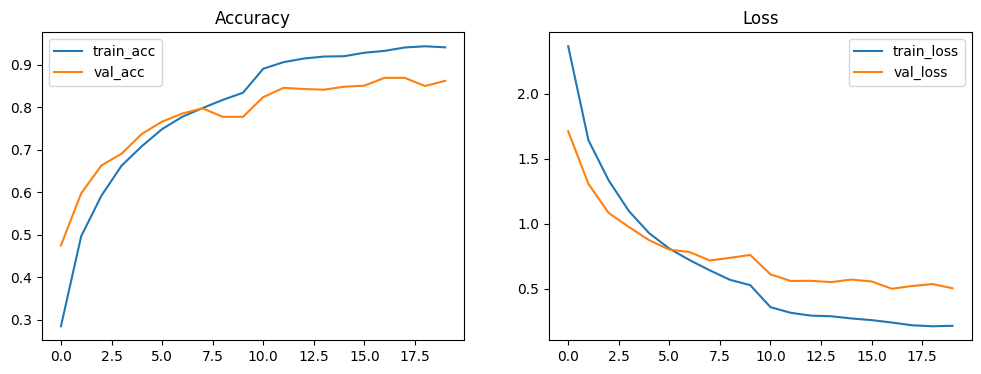

In [ ]:

import matplotlib.pyplot as plt
def plot_history(h):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history)


36/36 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8632 - loss: 0.4866
Validation loss: 0.5165711045265198 Validation acc: 0.8620087504386902
36/36 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step
Classification Report:
              precision    recall  f1-score   support

        Audi       0.79      0.84      0.81        55
     Bentley       0.98      0.87      0.92        68
        Benz       0.87      0.77      0.81        43
         Bmw       0.65      0.83      0.73        48
    Cadillac       0.85      0.91      0.88        64
       Dodge       0.92      0.87      0.89        62
     Ferrari       0.86      0.95      0.90        60
        Ford       0.83      0.89      0.86        62
Ford mustang       0.86      0.75      0.80        73
         Kia       0.93      0.85      0.89        61
 Lamborghini       0.93      0.90      0.91        70
       Lexus       0.86      0.81      0.83        67
    Maserati       0.91      0.90      0.91        70
     Porsche       0.81      0.90    

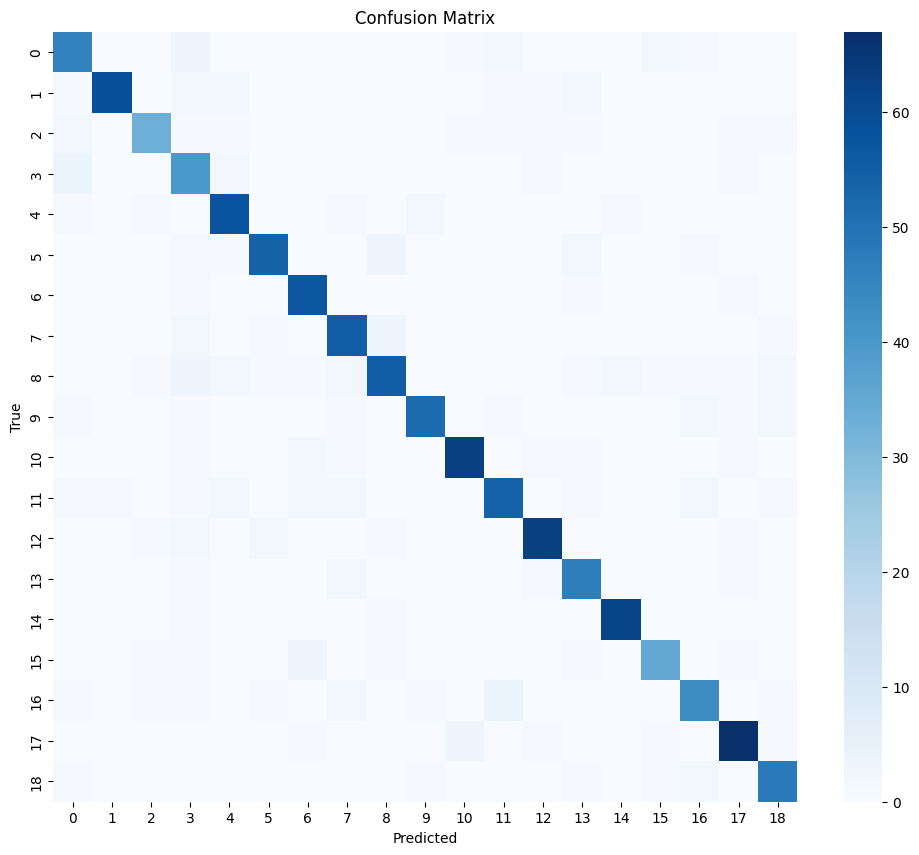

In [ ]:

val_loss, val_acc = model_transfer.evaluate(validation_generator, verbose=1)
print("Validation loss:", val_loss, "Validation acc:", val_acc)

# Predictions and classification report
Y_pred = model_transfer.predict(validation_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix 
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


In [18]:
IMAGE_LIST = [
    "/content/images3.jpg",
    "/content/images4.jpg",
    "/content/images8.jpg"
]



====== FINAL PREDICTIONS AFTER TRAINING ======



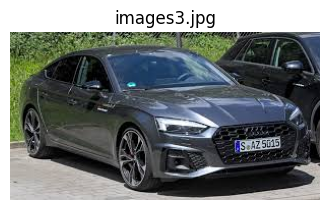

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Inception Prediction for /content/images3.jpg: Audi  (prob: 0.9972)
--------------------------------------------------


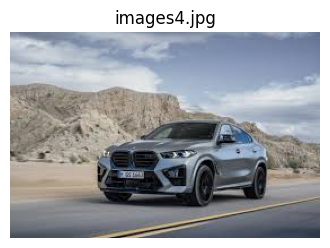

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Inception Prediction for /content/images4.jpg: Bmw  (prob: 0.8947)
--------------------------------------------------


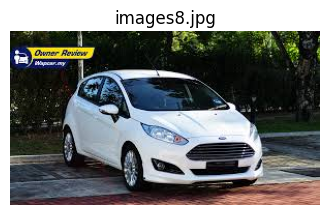

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Inception Prediction for /content/images8.jpg: Ford  (prob: 0.9088)
--------------------------------------------------


In [ ]:



from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def predict_with_inception(img_path, model=model_transfer, preprocess_fn=inception_preprocess, generator=train_generator):
 
    img_disp = Image.open(img_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img_disp)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = img_to_array(img)
    arr = preprocess_fn(arr)
    arr = np.expand_dims(arr, axis=0)


    pred = model.predict(arr)
    idx = np.argmax(pred[0])
    classes = list(generator.class_indices.keys())
    print(f"Inception Prediction for {img_path}: {classes[idx]}  (prob: {pred[0][idx]:.4f})")
    return classes[idx], float(pred[0][idx])


print("\n====== FINAL PREDICTIONS AFTER TRAINING ======\n")
for p in IMAGE_LIST:
    if not os.path.exists(p):
        print("Image not found:", p); continue
    predict_with_inception(p)
    print("--------------------------------------------------")

In [ ]:

Y_pred_inc = inception_model.predict(val_inc)
y_pred_inc = np.argmax(Y_pred_inc, axis=1)


y_true_inc = val_inc.classes


class_names_inc = list(val_inc.class_indices.keys())


cm_inc = confusion_matrix(y_true_inc, y_pred_inc)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_inc, annot=False, cmap="Blues",
            xticklabels=class_names_inc,
            yticklabels=class_names_inc)
plt.title("Confusion Matrix - InceptionV3")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report - InceptionV3:\n")
print(classification_report(y_true_inc, y_pred_inc, target_names=class_names_inc))
